# 2 DoF System
Here it is the problem statement in a single figure... beams are uniform, slender and massless, the dynamic degrees of freedom are the masses' vertical displacements but we need also the upper right rotation to take into account the external couple that excites the system.

![](figures/trab01_conv.svg)

Let's start with a few imports

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import eigh
from IPython.display import Latex, HTML

Next, we define some helper functions, `p` deals with creating polynomial objects, `i` given two polys and a length computes the definite integral of the polys' product, `pmat` formats a 2D array object for MathJax diplay and finally `dl` is an helper to actually display mathematical expressions using MJ.

In [2]:
def p(*l):
    'wrapper around poly1d class to modify call syntax'
    return np.poly1d(l)

def i(p,q,l):
    '''computes definite integral of p*q from 0 to l
    p and q are instances of poly1d class'''
    pqi = (p*q).integ()
    return pqi(l)-pqi(0)

def pmat(mat, fmt='%.3f'):
    'returns a LaTeX string representing a 2D array'
    inside =  r'\\'.join('&'.join(fmt%x for x in row) for row in mat)
    return r'\begin{bmatrix}'+inside+r'\end{bmatrix}'

def dl(s):
    'rich display a LaTeX string (surrounded by "$$")'
    display(Latex('$$'+s+'$$'))

We want to compute the 3x3 flexibility, next the 3x3 stiffness and the 2x2 stiffness plus the effects of the external load on the eq.s of equilibrium related to the dynamic degrees of freedom.

![](figures/bm01_conv.svg)

We start collecting the polynomials describing bending moments in a 2D data structure and then computing all the relevant integrals to have the 3x3 flexibility, then it's just following the book...

In [3]:
Ms = [[p(1.0, 0), p(1.0, 0), p(0.0, 0), p( 0.0, 0)],
      [p(0.5, 0), p(0.5, 0), p(0.5, 0), p( 0.5, 0)],
      [p(0.5, 0), p(0.5, 0), p(0.5, 0), p(-0.5, 1)],
     ]
Ls = [1, 1, 1, 1]

F = np.array([[sum(i(*mcl) for mcl in zip(M, C, Ls))
                   for M in Ms] for C in Ms])

dl(r'\boldsymbol F = \frac{EJ}{12L^3}'+pmat(12*F))


<IPython.core.display.Latex object>

In [17]:
K33 = np.linalg.inv(F)

Kdd, Kds = K33[:2,:2], K33[:2,2:]
Ksd, Kss = K33[2:,:2], K33[2:,2:]

display(HTML('<h3>The 3x3 stiffness</h3>'))
dl(r'\boldsymbol K_{(3,3)} = \frac{3}{14}\,\frac{EJ}{L^3}\,'+pmat(14*K33/3))
K = np.linalg.inv(F[:2,:2])
display(HTML('<h3>The 2x2 structural matrices</h3>'))
dl(r'\boldsymbol K = \frac{EJ}{L^3}\,'+pmat(K))
M = np.array(((2,0), (0,3)))
dl(r'\boldsymbol M = m\,'+pmat(M))
display(HTML('<h3>The nodal loads in terms of the external load</h3>'))
nodal_forces = -Kds@np.linalg.inv(Kss)
dl(r'\boldsymbol p(t) ='+pmat(nodal_forces)+'\,W(t)/L')

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

The eigenvalues, the eigenvector matrix (normalized so that $\boldsymbol\Psi$ has integer coefficients and it is symmetric) and the modal mass matrix.

In [8]:
evals, evecs = eigh(K, M)
dl(r'\omega^2 = \omega_0^2\,'+pmat(evals[:,None]))
evecs[:,0] /= evecs[1,0]
evecs[:,1] /= evecs[0,1]
evecs *= 2
dl(r'\boldsymbol\Psi = '+pmat(evecs))

Mstar = evecs.T@M@evecs
dl(r'\boldsymbol M^\star = m\,' +pmat(Mstar))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Now the modal forces, note that these are _normalized_ with respect to the modal masses, so that we can simplify the appearance of the modal eq.s of equilibrium

In [22]:
modal_forces = np.linalg.inv(Mstar)@evecs.T@nodal_forces
dl(r'\boldsymbol p^\star ='+pmat(modal_forces)+r'\,\frac{W(t)}{mL} =' +
   pmat(modal_forces) +
  r'\Delta \frac{EJ}{mL^3}\sin2\omega_0t =' + )

<IPython.core.display.Latex object>

And here the modal eq.s of equilibrium

In [23]:
display(HTML('<h2>Modal equation of motion</h2>'))
for j in (0, 1):
    i = j+1
    dl(r'\, \ddot q_%d + %.3f\, \omega_0^2\, q_%d = %+.3f\Delta \omega_0^2\sin(2\omega_0t)'%
      (i,evals[j],i,modal_forces[j,0]))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [16]:
freqs = np.sqrt(evals)
display(HTML('<h3>Modal frequencies</h3>'))    
dl(',\\qquad'.join(r'\omega_%d=%.6f\omega_0'%(i+1, freq) for i, freq in enumerate(freqs))+'.')

<IPython.core.display.Latex object>

The excitation is sinusoidal with frequency $\omega=2\omega_0$, so it is the particular integral, $\xi_i = C_i\sin2\omega_0t$. Substituting in the modal equations LHS we have 
$$ \xi_i(t) = \frac{p^\star_i(t)}{(\lambda_i^2-2^2)\,\omega_0^2}$$

In [24]:
display(HTML('<h2>Particular Integrals</h2>'))
c = modal_forces.flatten()/(evals-4)
for j in (0, 1):
    i = j+1
    dl(r'\xi_%d(t) = %+.6f\,\Delta\,\sin(2\omega_0t)'%(i, c[j]))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

The modal responses are given by the superposition of the particular integral and the homogeneous solution, where the constants of integration are chosen to fit the initial conditions.  For a sinusoidal p.i. and rest initial conditions, it is well known that $$q_i=C_i\big(sin\omega t - (\sin\omega_it)\omega/\omega_i)\big)$$

In [27]:
display(HTML('<h2>Modal Responses</h2>'))
a = -2*c/freqs
for j in (0, 1):
    i = j+1
    dl(r'q_%d(t) = \big(%+.6f\sin(2\,\omega_0t)%+.6f\sin(%.6f\,\omega_0t)\big)\Delta' %
       (i, c[j], a[j], freqs[j]))
    

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

It is now possible to plot the stuff that we have computed, for a time interval grater than what was requested.

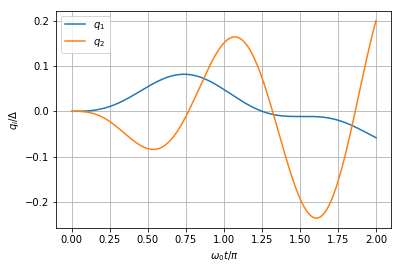

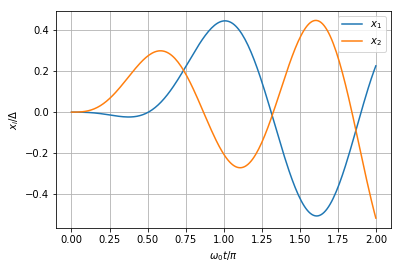

In [28]:
# adimensional time vector
w0t = np.linspace(0, 6.2831, 201)

# Modal responses
q1 = c[0]*np.sin(2*w0t)+a[0]*np.sin(freqs[0]*w0t)
q2 = c[1]*np.sin(2*w0t)+a[1]*np.sin(freqs[1]*w0t)

# Plot the modal responses
plt.plot(w0t/np.pi,q1,label='$q_1$')
plt.plot(w0t/np.pi,q2,label='$q_2$')
plt.legend(loc='best')
plt.xlabel(r'$\omega_0t/\pi$')
plt.ylabel(r'$q_i/\Delta$')
plt.grid()
plt.show()

# Nodal responses
x1 = q1*evecs[0,0]+q2*evecs[0,1]
x2 = q1*evecs[1,0]+q2*evecs[1,1]

# Plot the nodal responses
plt.plot(w0t/np.pi,x1,label='$x_1$')
plt.plot(w0t/np.pi,x2,label='$x_2$')
plt.legend(loc='best')
plt.xlabel(r'$\omega_0t/\pi$')
plt.ylabel(r'$x_i/\Delta$')
plt.grid()
plt.show()

The displacement $x_2(\pi)$ is approximately equal to $-0.2\Delta$.